In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
from comparers import ModelComparer
from explainers import generate_shap_explanations
from plots import plot_decision_boundary, plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                  plot_feature_effects, plot_forces
from util import calc_feature_order, calc_class_order, calc_instance_order
shap.initjs()
%matplotlib inline
task_name = '01'

In [2]:
try:
    with open(task_name + '.dataset', 'rb') as f:
        X, y, feature_names = pickle.load(f)
    with open(task_name + '.models', 'rb') as f:
        comparer = pickle.load(f)
    with open(task_name + '.expl', 'rb') as f:
        explanations = pickle.load(f)
    print('loaded saved state')
except FileNotFoundError:
    pass

# Setup Task

In [4]:
X, y = make_moons(n_samples=300, noise=0.3, random_state=0)
X *= 100
feature_names = np.array(['x1', 'x2'])
with open(task_name + '.dataset', 'wb') as f:
    pickle.dump((X, y, feature_names), f, pickle.HIGHEST_PROTOCOL)

In [32]:
from sklearn.svm import SVC
ref_model = SVC()
ref_model.fit(X, y)

SVC()

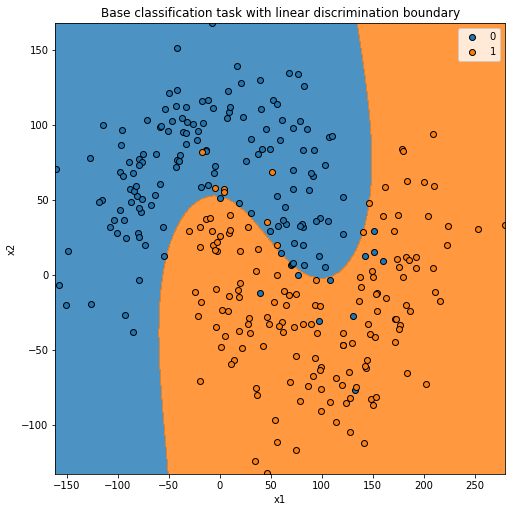

In [33]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Base classification task with linear discrimination boundary', feature_names,
                       predict=ref_model.predict, class_names=ref_model.classes_,
                       fig=fig, ax=ax)

In [40]:
clf_a = ref_model

In [34]:
clf_b = SVC(C=0.1)
clf_b.fit(X, y)

SVC(C=0.1)

In [41]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)
with open(task_name + '.models', 'wb') as f:
    cloudpickle.dump(comparer, f, pickle.HIGHEST_PROTOCOL)

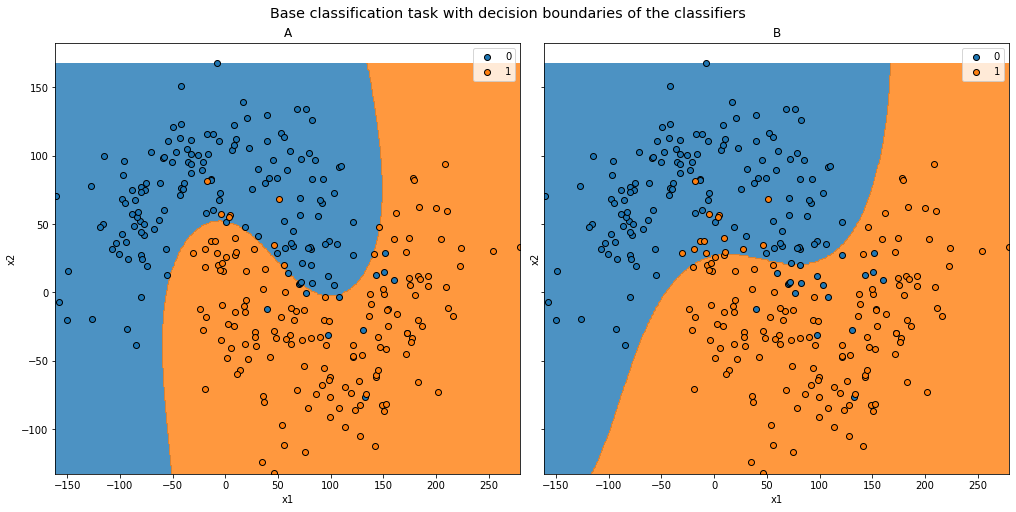

In [42]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')

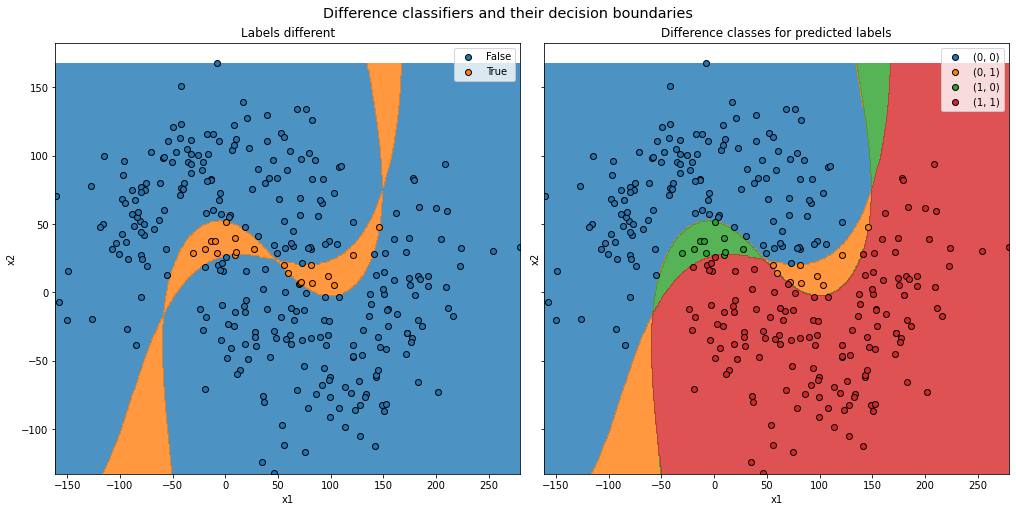

In [43]:
comparer.plot_decision_boundaries(X)

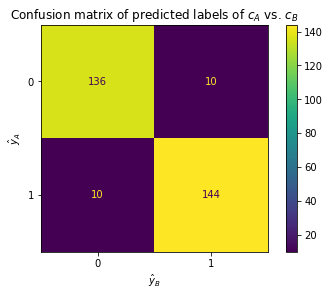

In [44]:
comparer.plot_confusion_matrix(X)

# Explain using Interpretability Methods

In [45]:
%%time
explanations = generate_shap_explanations(comparer, X, space_types=['labels'])
with open(task_name + '.expl', 'wb') as f:
    pickle.dump(explanations, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 301it [00:13, 13.19it/s]                         


CPU times: user 30 s, sys: 635 ms, total: 30.6 s
Wall time: 35.9 s


## Visualize SHAP values

### Individual explanations

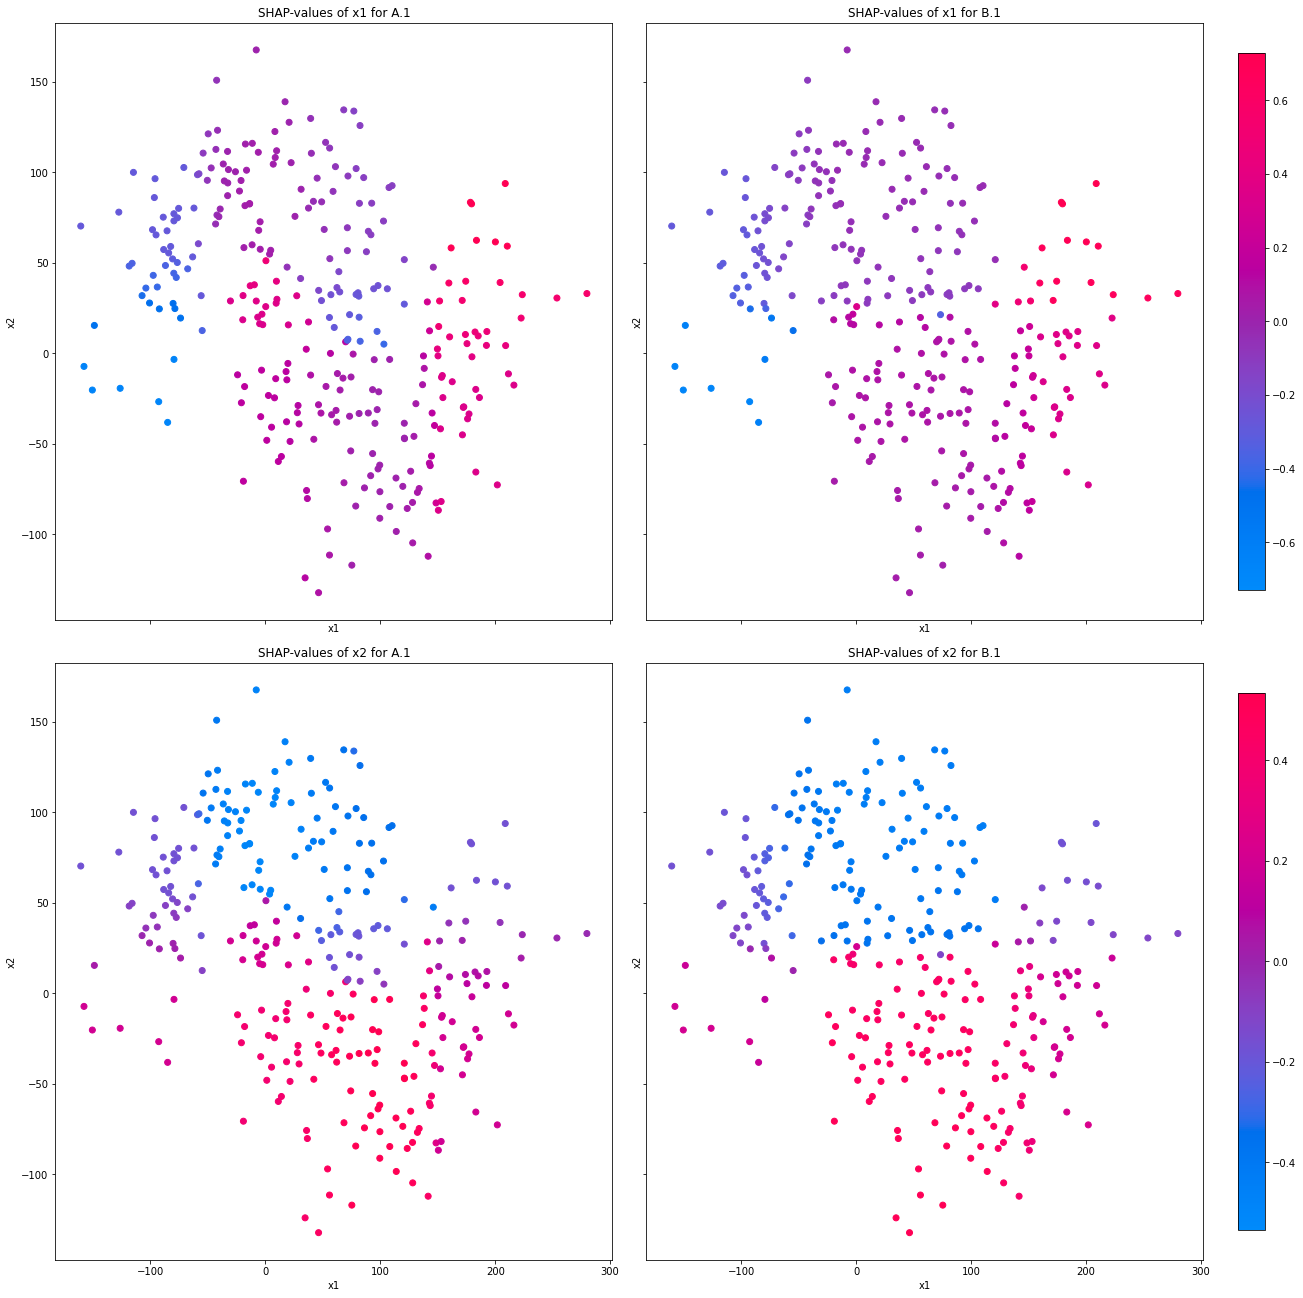

In [46]:
plot_2d(explanations.indiv.labels[:, :, 1])

### Simple subtraction explanation

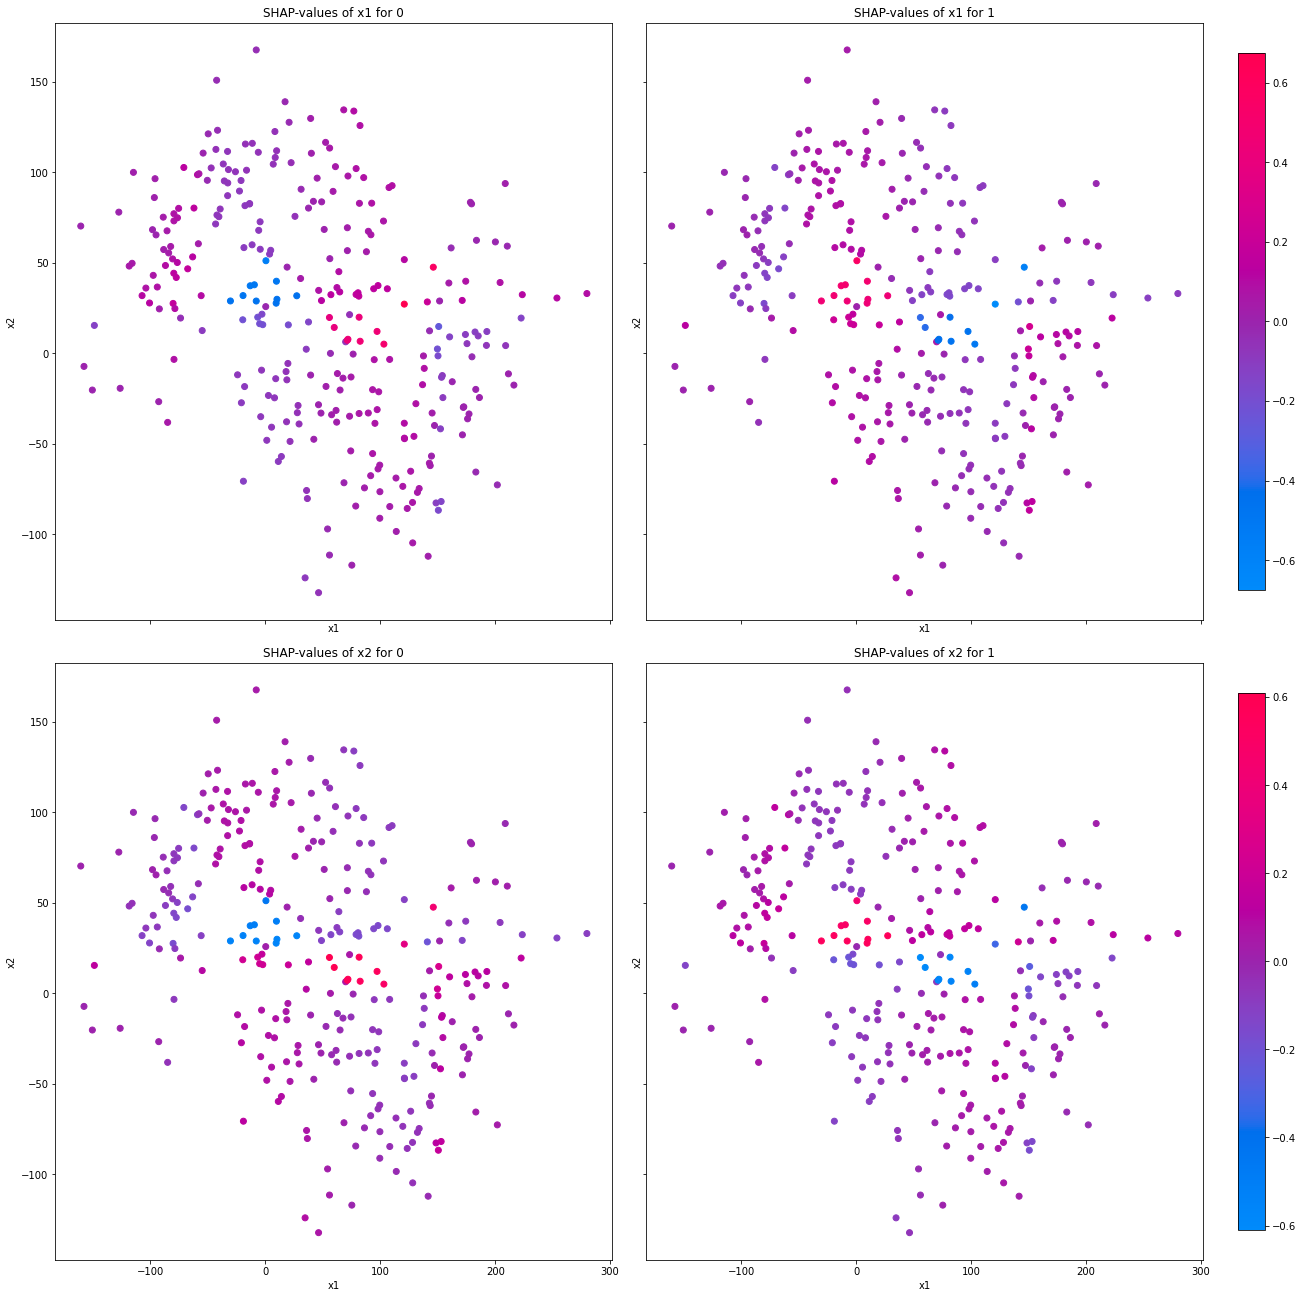

In [47]:
plot_2d(explanations.indiv_diff.labels)

### Multiclass difference classifier explanations

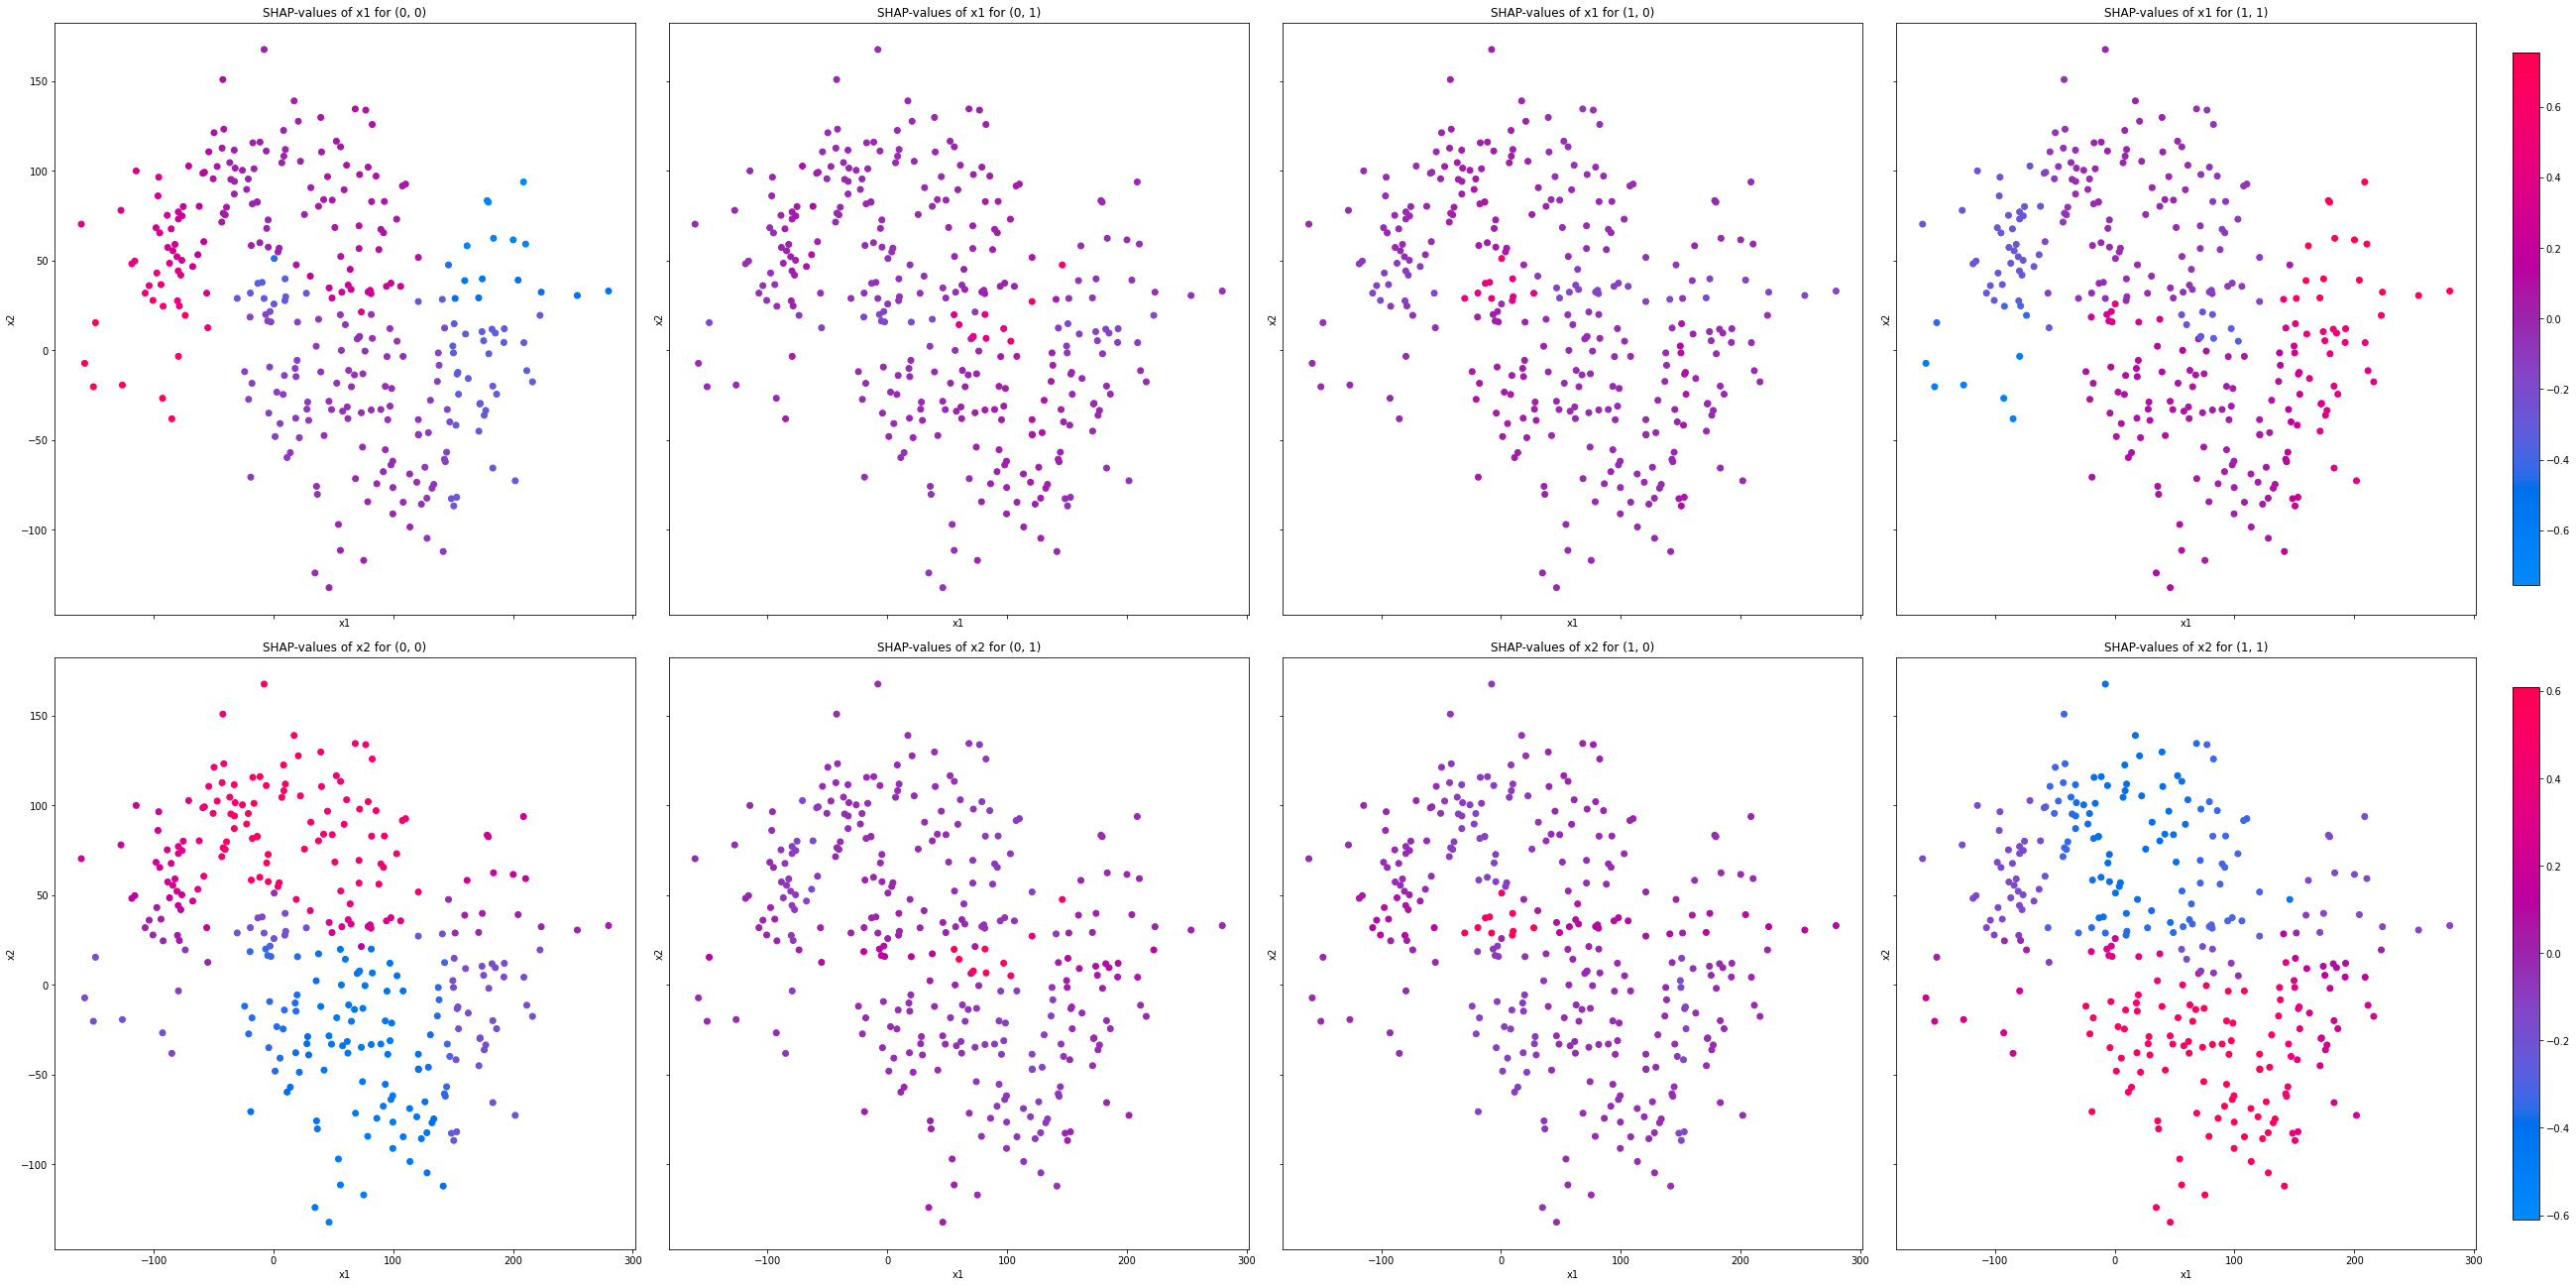

In [48]:
plot_2d(explanations.mclass_diff.labels)

## Feature importance

### Individual explanations

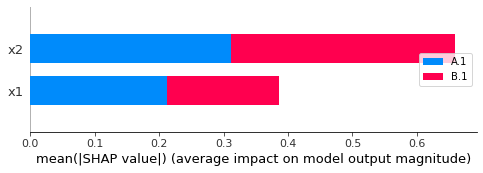

In [49]:
plot_feature_importance_bar(explanations.indiv.labels[:, :, 1])

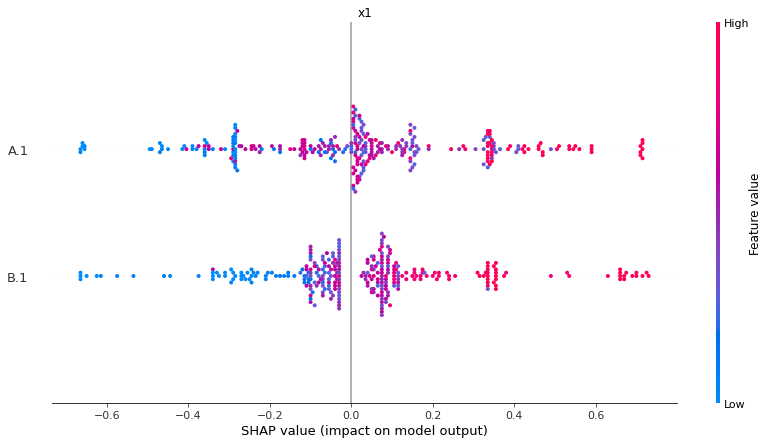

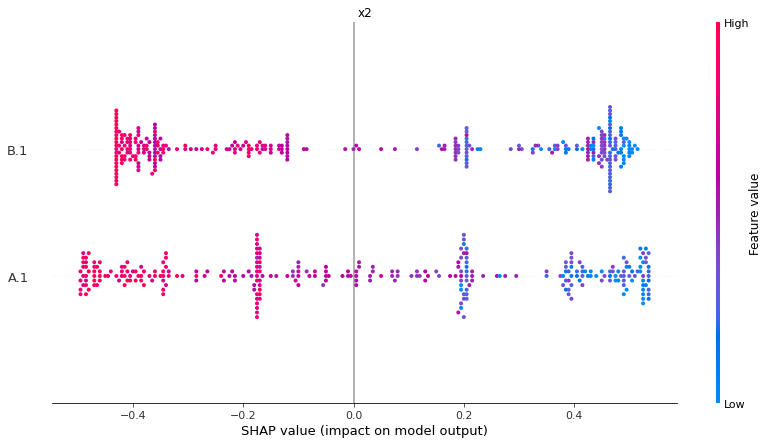

In [50]:
plot_feature_importance_scatter(explanations.indiv.labels[:, :, 1])

### Simple subtraction explanation

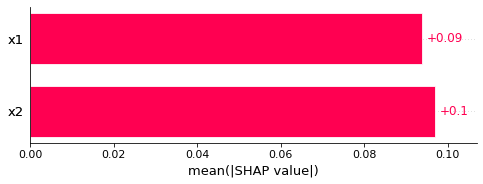

In [51]:
plot_feature_importance_bar(explanations.indiv_diff.labels[:, :, 1])

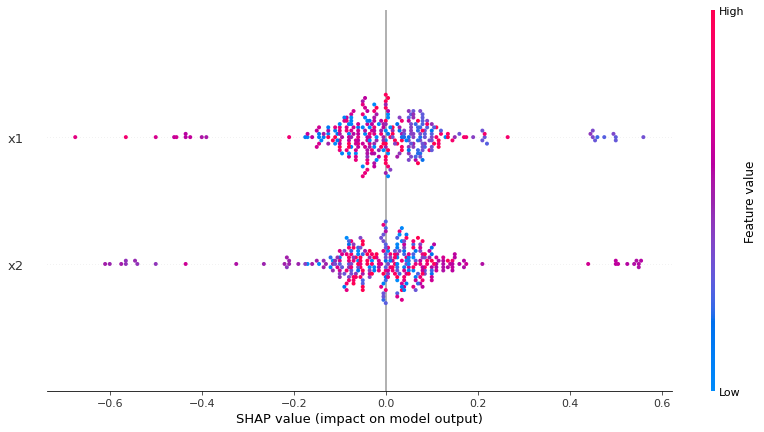

In [52]:
plot_feature_importance_scatter(explanations.indiv_diff.labels[:, :, 1])

### Multiclass difference classifier explanations

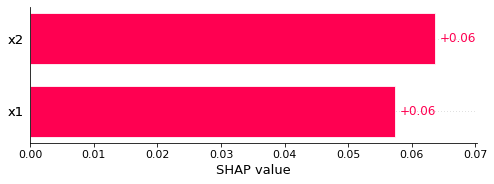

In [53]:
feature_order, feature_importance = calc_feature_order(explanations.mclass_diff.labels[:, :, comparer.difference_class_names])
plot_feature_importance_bar(feature_importance)

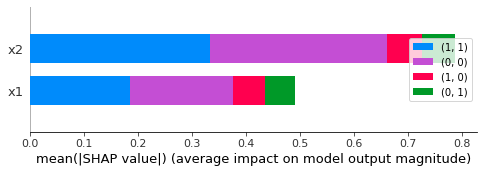

In [54]:
plot_feature_importance_bar(explanations.mclass_diff.labels)

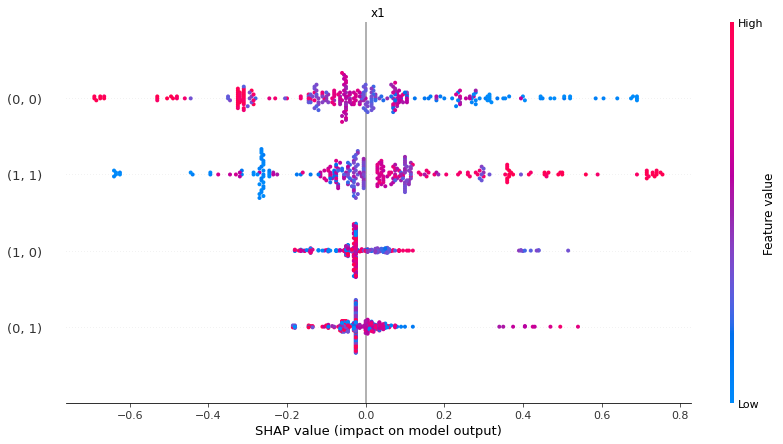

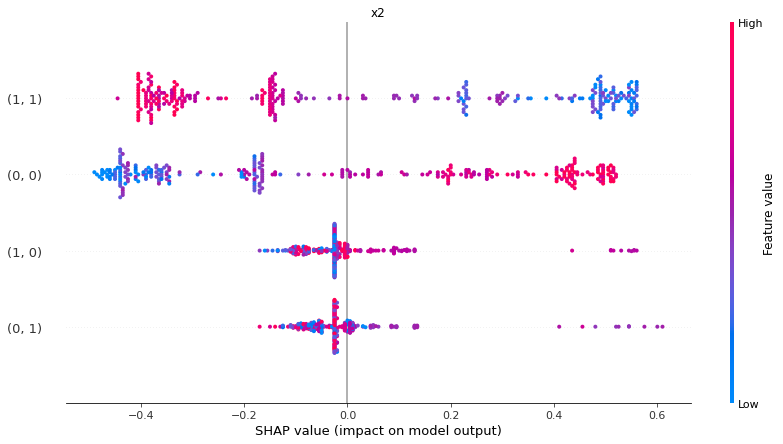

In [55]:
plot_feature_importance_scatter(explanations.mclass_diff.labels)

## Feature effects

### Individual explanations

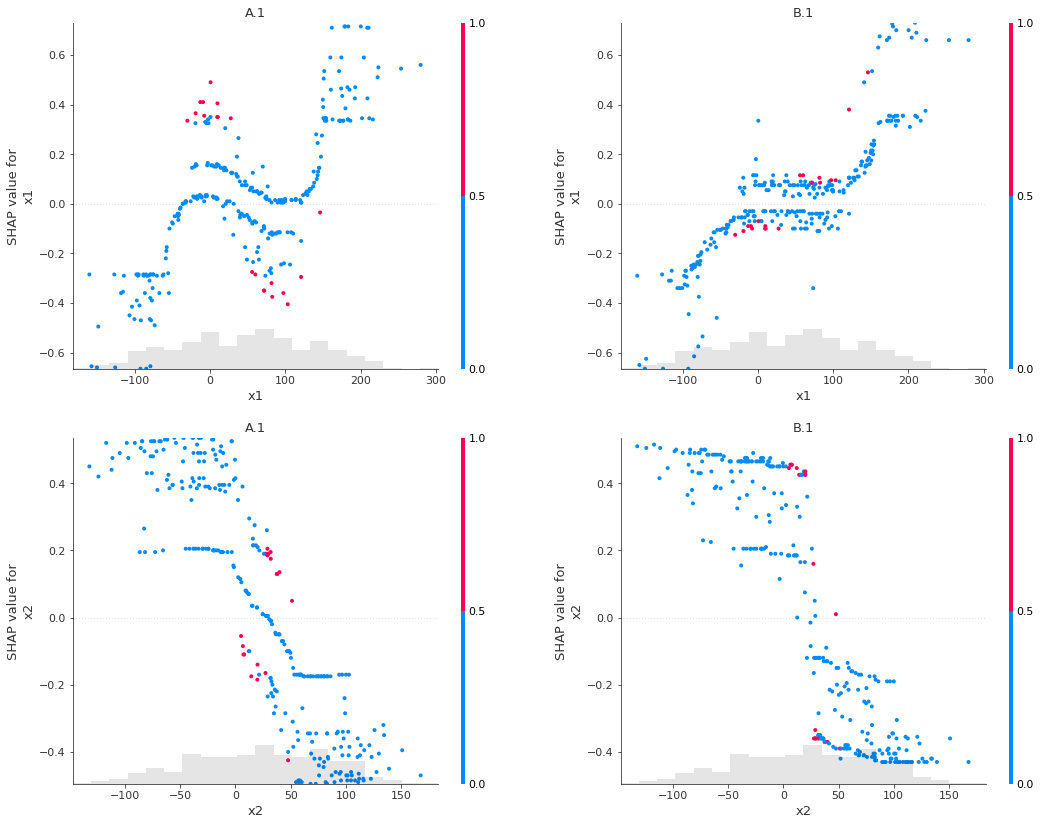

In [56]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
plot_feature_effects(explanations.indiv.labels[:, :, 1], color=is_pred_diff)

### Simple subtraction explanation

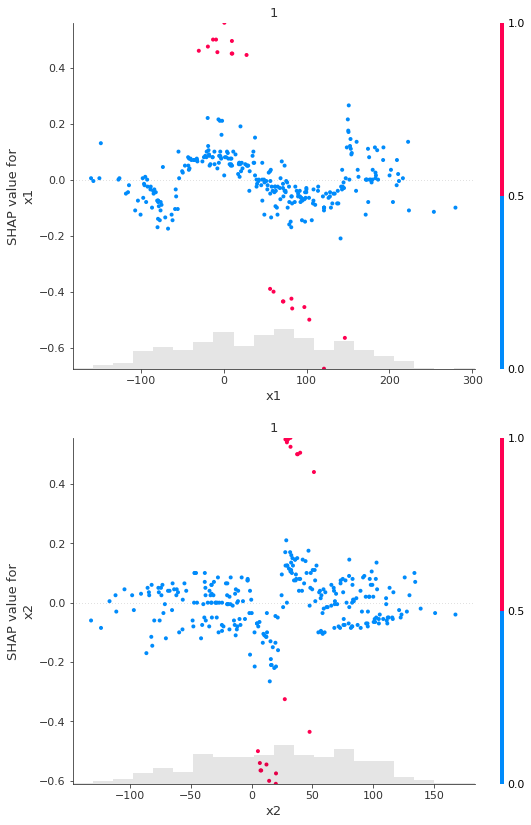

In [57]:
plot_feature_effects(explanations.indiv_diff.labels[:, :, 1], color=is_pred_diff)

### Multiclass difference classifier explanations

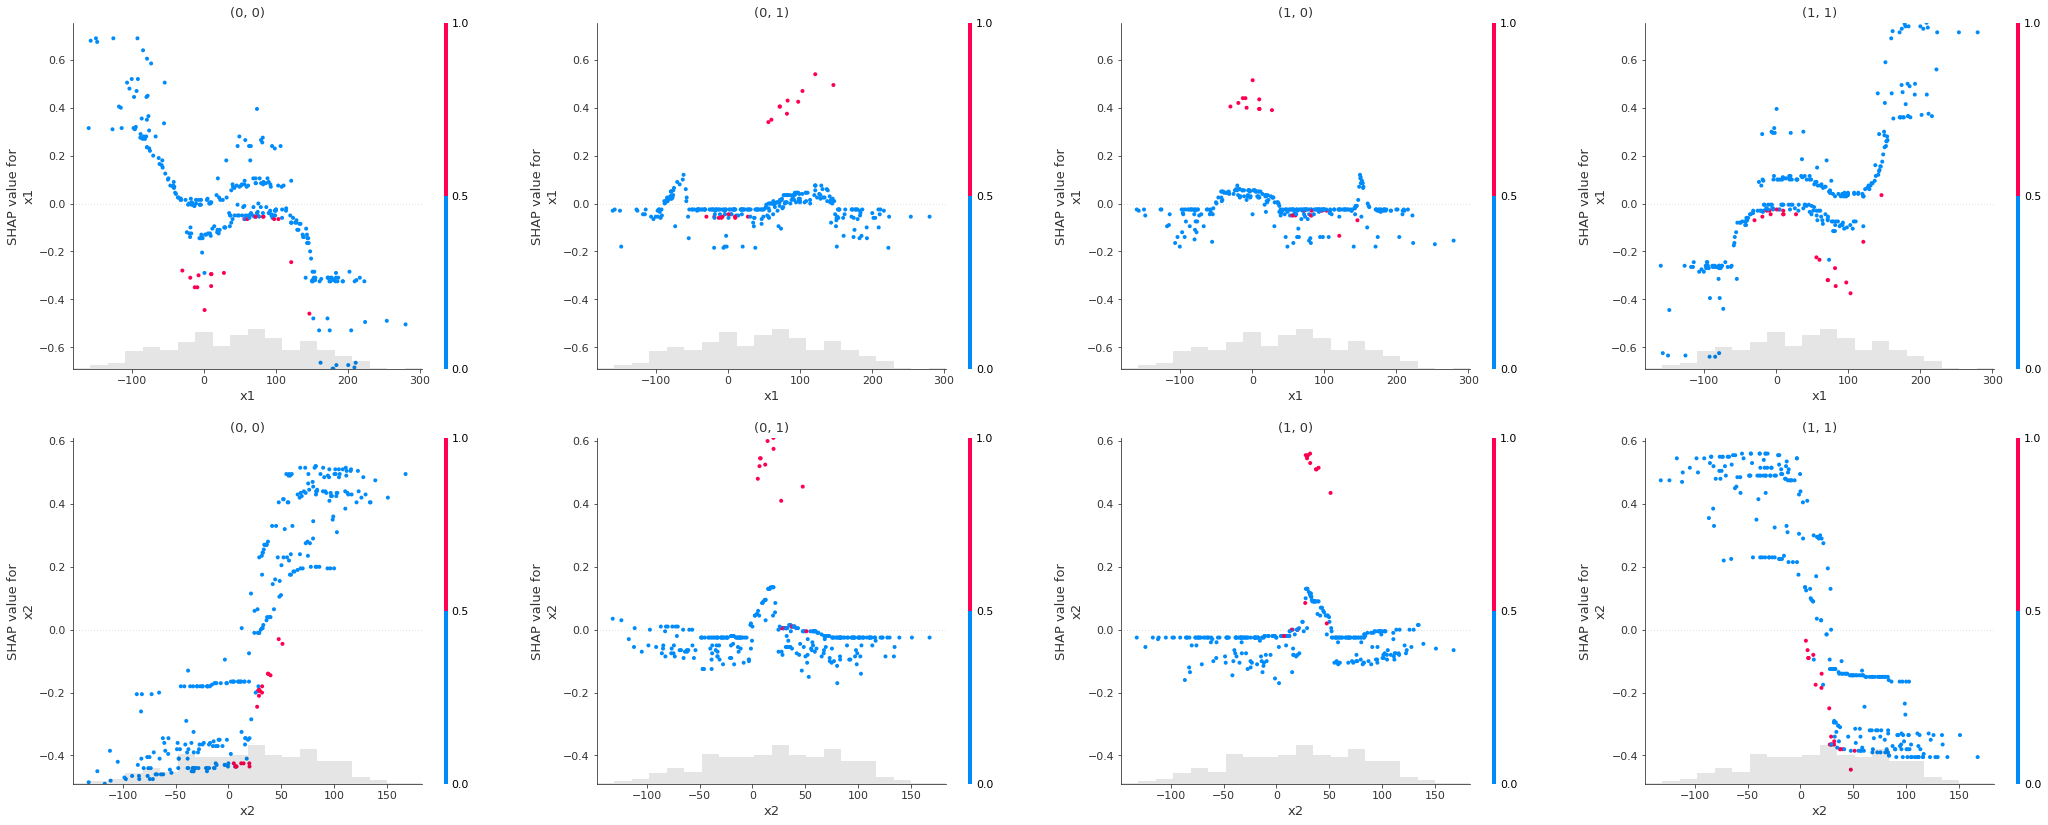

In [58]:
plot_feature_effects(explanations.mclass_diff.labels, color=is_pred_diff)

## Cluster instances

### Individual explanations

In [59]:
instance_order = calc_instance_order(explanations)
plot_forces(explanations.indiv.labels[:, :, 1], instance_order=instance_order)

### Simple subtraction explanation

In [60]:
plot_forces(explanations.indiv_diff.labels, instance_order=instance_order)

### Multiclass difference classifier explanations

In [61]:
plot_forces(explanations.mclass_diff.labels[:, :, comparer.difference_class_names], instance_order=instance_order)